# Artificial Intelligence Engineer Nanodegree - Probabilistic Models
## Project: Sign Language Recognition System
- [Introduction](#intro)
- [Part 1 Feature Selection](#part1_tutorial)
    - [Tutorial](#part1_tutorial)
    - [Features Submission](#part1_submission)
    - [Features Unittest](#part1_test)
- [Part 2 Train the models](#part2_tutorial)
    - [Tutorial](#part2_tutorial)
    - [Model Selection Score Submission](#part2_submission)
    - [Model Score Unittest](#part2_test)
- [Part 3 Build a Recognizer](#part3_tutorial)
    - [Tutorial](#part3_tutorial)
    - [Recognizer Submission](#part3_submission)
    - [Recognizer Unittest](#part3_test)
- [Part 4 (OPTIONAL) Improve the WER with Language Models](#part4_info)

<a id='intro'></a>
## Introduction
The overall goal of this project is to build a word recognizer for American Sign Language video sequences, demonstrating the power of probabalistic models.  In particular, this project employs  [hidden Markov models (HMM's)](https://en.wikipedia.org/wiki/Hidden_Markov_model) to analyze a series of measurements taken from videos of American Sign Language (ASL) collected for research (see the [RWTH-BOSTON-104 Database](http://www-i6.informatik.rwth-aachen.de/~dreuw/database-rwth-boston-104.php)).  In this video, the right-hand x and y locations are plotted as the speaker signs the sentence.
[![ASLR demo](http://www-i6.informatik.rwth-aachen.de/~dreuw/images/demosample.png)](https://drive.google.com/open?id=0B_5qGuFe-wbhUXRuVnNZVnMtam8)

The raw data, train, and test sets are pre-defined.  You will derive a variety of feature sets (explored in Part 1), as well as implement three different model selection criterion to determine the optimal number of hidden states for each word model (explored in Part 2). Finally, in Part 3 you will implement the recognizer and compare the effects the different combinations of feature sets and model selection criteria.  

At the end of each Part, complete the submission cells with implementations, answer all questions, and pass the unit tests.  Then submit the completed notebook for review!

<a id='part1_tutorial'></a>
## PART 1: Data

### Features Tutorial
##### Load the initial database
A data handler designed for this database is provided in the student codebase as the `AslDb` class in the `asl_data` module.  This handler creates the initial [pandas](http://pandas.pydata.org/pandas-docs/stable/) dataframe from the corpus of data included in the `data` directory as well as dictionaries suitable for extracting data in a format friendly to the [hmmlearn](https://hmmlearn.readthedocs.io/en/latest/) library.  We'll use those to create models in Part 2.

To start, let's set up the initial database and select an example set of features for the training set.  At the end of Part 1, you will create additional feature sets for experimentation. 

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from asl_data import AslDb

asl = AslDb() # initializes the database
asl.df.head() # displays the first five rows of the asl database, indexed by video and frame

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker
video frame                                                           
98    0         149     181      170      175     161      62  woman-1
      1         149     181      170      175     161      62  woman-1
      2         149     181      170      175     161      62  woman-1
      3         149     181      170      175     161      62  woman-1
      4         149     181      170      175     161      62  woman-1

In [26]:
asl.df.ix[98,1]  # look at the data available for an individual frame

left-x         149
left-y         181
right-x        170
right-y        175
nose-x         161
nose-y          62
speaker    woman-1
grnd-ry        113
grnd-rx          9
grnd-ly        119
grnd-lx        -12
Name: (98, 1), dtype: object

The frame represented by video 98, frame 1 is shown here:
![Video 98](http://www-i6.informatik.rwth-aachen.de/~dreuw/database/rwth-boston-104/overview/images/orig/098-start.jpg)

##### Feature selection for training the model
The objective of feature selection when training a model is to choose the most relevant variables while keeping the model as simple as possible, thus reducing training time.  We can use the raw features already provided or derive our own and add columns to the pandas dataframe `asl.df` for selection. As an example, in the next cell a feature named `'grnd-ry'` is added. This feature is the difference between the right-hand y value and the nose y value, which serves as the "ground" right y value. 

In [27]:
asl.df['grnd-ry'] = asl.df['right-y'] - asl.df['nose-y']
asl.df.head()  # the new feature 'grnd-ry' is now in the frames dictionary

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  
video frame                                      
98    0          113        9      119      -12  
      1          113        9      119      -12  
      2          113        9      119      -12  
      3          113        9      119      -12  
      4          113        9      119      -12

##### Try it!

In [28]:
from asl_utils import test_features_tryit
# TODO add df columns for 'grnd-rx', 'grnd-ly', 'grnd-lx' representing differences between hand and nose locations
asl.df['grnd-rx'] = asl.df['right-x'] - asl.df['nose-x']
asl.df['grnd-ly'] = asl.df['left-y'] - asl.df['nose-y']
asl.df['grnd-lx'] = asl.df['left-x'] - asl.df['nose-x']

# test the code
test_features_tryit(asl)

asl.df sample


left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  
video frame                                      
98    0          113        9      119      -12  
      1          113        9      119      -12  
      2          113        9      119      -12  
      3          113        9      119      -12  
      4          113        9      119      -12

In [29]:
# collect the features into a list
features_ground = ['grnd-rx','grnd-ry','grnd-lx','grnd-ly']
 #show a single set of features for a given (video, frame) tuple
[asl.df.ix[98,1][v] for v in features_ground]

[9, 113, -12, 119]

##### Build the training set
Now that we have a feature list defined, we can pass that list to the `build_training` method to collect the features for all the words in the training set.  Each word in the training set has multiple examples from various videos.  Below we can see the unique words that have been loaded into the training set:

In [6]:
training = asl.build_training(features_ground)
print("Training words: {}".format(training.words))

Training words: ['JOHN', 'WRITE', 'HOMEWORK', 'IX-1P', 'SEE', 'YESTERDAY', 'IX', 'LOVE', 'MARY', 'CAN', 'GO', 'GO1', 'FUTURE', 'GO2', 'PARTY', 'FUTURE1', 'HIT', 'BLAME', 'FRED', 'FISH', 'WONT', 'EAT', 'BUT', 'CHICKEN', 'VEGETABLE', 'CHINA', 'PEOPLE', 'PREFER', 'BROCCOLI', 'LIKE', 'LEAVE', 'SAY', 'BUY', 'HOUSE', 'KNOW', 'CORN', 'CORN1', 'THINK', 'NOT', 'PAST', 'LIVE', 'CHICAGO', 'CAR', 'SHOULD', 'DECIDE', 'VISIT', 'MOVIE', 'WANT', 'SELL', 'TOMORROW', 'NEXT-WEEK', 'NEW-YORK', 'LAST-WEEK', 'WILL', 'FINISH', 'ANN', 'READ', 'BOOK', 'CHOCOLATE', 'FIND', 'SOMETHING-ONE', 'POSS', 'BROTHER', 'ARRIVE', 'HERE', 'GIVE', 'MAN', 'NEW', 'COAT', 'WOMAN', 'GIVE1', 'HAVE', 'FRANK', 'BREAK-DOWN', 'SEARCH-FOR', 'WHO', 'WHAT', 'LEG', 'FRIEND', 'CANDY', 'BLUE', 'SUE', 'BUY1', 'STOLEN', 'OLD', 'STUDENT', 'VIDEOTAPE', 'BORROW', 'MOTHER', 'POTATO', 'TELL', 'BILL', 'THROW', 'APPLE', 'NAME', 'SHOOT', 'SAY-1P', 'SELF', 'GROUP', 'JANA', 'TOY1', 'MANY', 'TOY', 'ALL', 'BOY', 'TEACHER', 'GIRL', 'BOX', 'GIVE2', 'GIVE3

The training data in `training` is an object of class `WordsData` defined in the `asl_data` module.  in addition to the `words` list, data can be accessed with the `get_all_sequences`, `get_all_Xlengths`, `get_word_sequences`, and `get_word_Xlengths` methods. We need the `get_word_Xlengths` method to train multiple sequences with the `hmmlearn` library.  In the following example, notice that there are two lists; the first is a concatenation of all the sequences(the X portion) and the second is a list of the sequence lengths(the Lengths portion).

In [7]:
training.get_word_Xlengths('CHOCOLATE')

(array([[-11,  48,   7, 120],
        [-11,  48,   8, 109],
        [ -8,  49,  11,  98],
        [ -7,  50,   7,  87],
        [ -4,  54,   7,  77],
        [ -4,  54,   6,  69],
        [ -4,  54,   6,  69],
        [-13,  52,   6,  69],
        [-13,  52,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [-10,  59,   7,  71],
        [-15,  64,   9,  77],
        [-17,  75,  13,  81],
        [ -4,  48,  -4, 113],
        [ -2,  53,  -4, 113],
        [ -4,  55,   2,  98],
        [ -4,  58,   2,  98],
        [ -1,  59,   2,  89],
        [ -1,  59,  -1,  84],
        [ -1,  59,  -1,  84],
        [ -7,  63,  -1,  84],
        [ -7,  63,  -1,  84],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ 

###### More feature sets
So far we have a simple feature set that is enough to get started modeling.  However, we might get better results if we manipulate the raw values a bit more, so we will go ahead and set up some other options now for experimentation later.  For example, we could normalize each speaker's range of motion with grouped statistics using [Pandas stats](http://pandas.pydata.org/pandas-docs/stable/api.html#api-dataframe-stats) functions and [pandas groupby](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html).  Below is an example for finding the means of all speaker subgroups.

In [30]:
df_means = asl.df.groupby('speaker').mean()
df_means

,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-rx,grnd-ly,grnd-lx
speaker,,,,,,,,,,
man-1,206.248203,218.679449,155.464350,150.371031,175.031756,61.642600,88.728430,-19.567406,157.036848,31.216447
woman-1,164.661438,161.271242,151.017865,117.332462,162.655120,57.245098,60.087364,-11.637255,104.026144,2.006318
woman-2,183.214509,176.527232,156.866295,119.835714,170.318973,58.022098,61.813616,-13.452679,118.505134,12.895536


To select a mean that matches by speaker, use the pandas [map](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.map.html) method:

In [31]:
asl.df['left-x-mean']= asl.df['speaker'].map(df_means['left-x'])
asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  left-x-mean  
video frame                                                   
98    0          113        9      119      -12   164.661438  
      1          113        9      119      -12   164.661438  
      2          113        9      119      -12   164.661438  
      3          113        9      119      -12   164.661438  
      4          113        9      119      -12   164.661438

##### Try it!

In [32]:
from asl_utils import test_std_tryit
# TODO Create a dataframe named `df_std` with standard deviations grouped by speaker
df_std = asl.df.groupby('speaker').std()

# test the code
test_std_tryit(df_std)

df_std


,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-rx,grnd-ly,grnd-lx,left-x-mean
speaker,,,,,,,,,,,
man-1,15.154425,36.328485,18.901917,54.902340,6.654573,5.520045,53.487999,20.269032,36.572749,15.080360,0.0
woman-1,17.573442,26.594521,16.459943,34.667787,3.549392,3.538330,33.972660,16.764706,27.117393,17.328941,0.0
woman-2,15.388711,28.825025,14.890288,39.649111,4.099760,3.416167,39.128572,16.191324,29.320655,15.050938,0.0


<a id='part1_submission'></a>
### Features Implementation Submission
Implement four feature sets and answer the question that follows.
- normalized Cartesian coordinates
    - use *mean* and *standard deviation* statistics and the [standard score](https://en.wikipedia.org/wiki/Standard_score) equation to account for speakers with different heights and arm length
    
- polar coordinates
    - calculate polar coordinates with [Cartesian to polar equations](https://en.wikipedia.org/wiki/Polar_coordinate_system#Converting_between_polar_and_Cartesian_coordinates)
    - use the [np.arctan2](https://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.arctan2.html) function and *swap the x and y axes* to move the $0$ to $2\pi$ discontinuity to 12 o'clock instead of 3 o'clock;  in other words, the normal break in radians value from $0$ to $2\pi$ occurs directly to the left of the speaker's nose, which may be in the signing area and interfere with results.  By swapping the x and y axes, that discontinuity move to directly above the speaker's head, an area not generally used in signing.

- delta difference
    - as described in Thad's lecture, use the difference in values between one frame and the next frames as features
    - pandas [diff method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.diff.html) and [fillna method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html) will be helpful for this one

- custom features
    - These are your own design; combine techniques used above or come up with something else entirely. We look forward to seeing what you come up with! 
    Some ideas to get you started:
        - normalize using a [feature scaling equation](https://en.wikipedia.org/wiki/Feature_scaling)
        - normalize the polar coordinates
        - adding additional deltas


In [33]:
# TODO add features for normalized by speaker values of left, right, x, y
# Name these 'norm-rx', 'norm-ry', 'norm-lx', and 'norm-ly'
# using Z-score scaling (X-Xmean)/Xstd

features_norm = ['norm-rx', 'norm-ry', 'norm-lx','norm-ly']

asl.df['left-y-mean'] = asl.df['speaker'].map(df_means['left-y'])
asl.df['right-x-mean'] = asl.df['speaker'].map(df_means['right-x'])
asl.df['right-y-mean'] = asl.df['speaker'].map(df_means['right-y'])

asl.df['left-x-std'] = asl.df['speaker'].map(df_std['left-x'])
asl.df['left-y-std'] = asl.df['speaker'].map(df_std['left-y'])
asl.df['right-x-std'] = asl.df['speaker'].map(df_std['right-x'])
asl.df['right-y-std'] = asl.df['speaker'].map(df_std['right-y'])

asl.df['norm-rx'] = (asl.df['right-x']-asl.df['right-x-mean'])/asl.df['right-x-std']
asl.df['norm-ry'] = (asl.df['right-y']-asl.df['right-y-mean'])/asl.df['right-y-std']
asl.df['norm-lx'] = (asl.df['left-x']-asl.df['left-x-mean'])/asl.df['left-x-std']
asl.df['norm-ly'] = (asl.df['left-y']-asl.df['left-y-mean'])/asl.df['left-y-std']

asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly    ...     right-x-mean  right-y-mean  \
video frame                               ...                                  
98    0          113        9      119    ...       151.017865    117.332462   
      1          113        9      119    ...       151.017865    117.332462   
      2          113        9      119    ...       151.017865    117.332462   
      3          113        9      119    ...       151.017865    117.332462   
      4          113        9      119    ...       151.017865    117.332462   

             left-x-std  left-y-std  right-x-std  right-y-std   norm-rx  \
video frame                                                               
98    0       17.573442   26.594521    16.459943    34.667787  1.153232   
      1       17.573442   26.594521    16.459943    34.667787  1.153232   
      2       17.573442   26.594521    16.459943    34.667787  1.153232   
      3       17.573442   26.594521    16.459943    34.667787  1.153232   
      4       17.573442   26.594521    16.459943    34.667787  1.153232   

              norm-ry   norm-lx   norm-ly  
video frame                                
98    0      1.663433 -0.891199  0.741835  
      1      1.663433 -0.891199  0.741835  
      2      1.663433 -0.891199  0.741835  
      3      1.663433 -0.891199  0.741835  
      4      1.663433 -0.891199  0.741835  

[5 rows x 23 columns]

In [34]:
# TODO add features for polar coordinate values where the nose is the origin
# Name these 'polar-rr', 'polar-rtheta', 'polar-lr', and 'polar-ltheta'
# Note that 'polar-rr' and 'polar-rtheta' refer to the radius and angle
from scipy.spatial import distance

features_polar = ['polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta']

asl.df['polar-rr'] = np.sqrt(np.power(asl.df['grnd-rx'], 2) + np.power(asl.df['grnd-ry'], 2))
asl.df['polar-rtheta'] = np.arctan2(asl.df['grnd-rx'], asl.df['grnd-ry']) # Swapping X and Y

asl.df['polar-lr'] = np.sqrt(asl.df['grnd-lx']**2 + asl.df['grnd-ly']**2)
asl.df['polar-ltheta'] = np.arctan2(asl.df['grnd-lx'], asl.df['grnd-ly']) # Swapping X and Y

In [35]:
# TODO add features for left, right, x, y differences by one time step, i.e. the "delta" values discussed in the lecture
# Name these 'delta-rx', 'delta-ry', 'delta-lx', and 'delta-ly'

features_delta = ['delta-rx', 'delta-ry', 'delta-lx', 'delta-ly']

asl.df['delta-rx'] = asl.df['right-x'].diff().fillna(0)
asl.df['delta-ry'] = asl.df['right-y'].diff().fillna(0)
asl.df['delta-lx'] = asl.df['left-x'].diff().fillna(0)
asl.df['delta-ly'] = asl.df['left-y'].diff().fillna(0)

asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly    ...      norm-lx   norm-ly  \
video frame                               ...                          
98    0          113        9      119    ...    -0.891199  0.741835   
      1          113        9      119    ...    -0.891199  0.741835   
      2          113        9      119    ...    -0.891199  0.741835   
      3          113        9      119    ...    -0.891199  0.741835   
      4          113        9      119    ...    -0.891199  0.741835   

              polar-rr  polar-rtheta    polar-lr  polar-ltheta  delta-rx  \
video frame                                                                
98    0      113.35784      0.079478  119.603512     -0.100501       0.0   
      1      113.35784      0.079478  119.603512     -0.100501       0.0   
      2      113.35784      0.079478  119.603512     -0.100501       0.0   
      3      113.35784      0.079478  119.603512     -0.100501       0.0   
      4      113.35784      0.079478  119.603512     -0.100501       0.0   

             delta-ry  delta-lx  delta-ly  
video frame                                
98    0           0.0       0.0       0.0  
      1           0.0       0.0       0.0  
      2           0.0       0.0       0.0  
      3           0.0       0.0       0.0  
      4           0.0       0.0       0.0  

[5 rows x 31 columns]

In [125]:
# TODO add features of your own design, which may be a combination of the above or something else
# Name these whatever you would like

# TODO define a list named 'features_custom' for building the training set

from scipy.stats import zscore


features_custom = ['delta-polar-rr', 'delta-polar-rtheta', 'delta-polar-lr', 'delta-polar-ltheta']
asl.df['delta-polar-rr'] = asl.df['polar-rr'].diff().fillna(0)
asl.df['delta-polar-rtheta'] = asl.df['polar-rtheta'].diff().fillna(0)
asl.df['delta-polar-lr'] = asl.df['polar-lr'].diff().fillna(0)
asl.df['delta-polar-ltheta'] = asl.df['polar-ltheta'].diff().fillna(0)

df_means = asl.df.groupby('speaker').mean()
df_std = asl.df.groupby('speaker').std()

def my_map(df):
    return asl.df['speaker'].map(df)

def normalize(col_name):
    return (asl.df[col_name] - my_map(df_means[col_name]))/my_map(df_std[col_name])

# Normalized deltas account for speaker's speed
features_custom += ['norm-delta-rx', 'norm-delta-ry', 'norm-delta-lx', 'norm-delta-ry']
asl.df['norm-delta-rx'] = normalize('delta-rx')
asl.df['norm-delta-ry'] = normalize('delta-ry')
asl.df['norm-delta-lx'] = normalize('delta-lx')
asl.df['norm-delta-ly'] = normalize('delta-ly')

# Normalized coordinates account for speaker's arm length and motion range
features_custom += ['norm-polar-rr', 'norm-polar-rtheta', 'norm-polar-lr', 'norm-polar-ltheta']
asl.df['norm-polar-rr'] = normalize('polar-rr')
asl.df['norm-polar-rtheta'] = normalize('polar-rtheta')
asl.df['norm-polar-lr'] = normalize('polar-lr')
asl.df['norm-polar-ltheta'] = normalize('polar-ltheta')

# Normalized deltas account for speaker's speed
features_custom += ['norm-delta-polar-rr', 'norm-delta-polar-rtheta', 'norm-delta-polar-lr', 'norm-delta-polar-ltheta']
asl.df['norm-delta-polar-rr'] = normalize('delta-polar-rr')
asl.df['norm-delta-polar-rtheta'] = normalize('delta-polar-rtheta')
asl.df['norm-delta-polar-lr'] = normalize('delta-polar-lr')
asl.df['norm-delta-polar-ltheta'] = normalize('delta-polar-ltheta')

# Position of right hand relative to left hand. Discarded, because grnd-rx, grnd-ry account for the same thing
# features_custom += ['delta-rlx', 'delta-rly']
# asl.df['delta-rlx'] = asl.df['right-x'] - asl.df['left-x']
# asl.df['delta-rly'] = asl.df['right-y'] - asl.df['left-y']

# Normalized distance from nose to hand account for speaker's height
features_custom += ['norm-grnd-rx', 'norm-grnd-ry', 'norm-grnd-lx', 'norm-grnd-ly']
asl.df['norm-grnd-rx'] = normalize('grnd-rx')
asl.df['norm-grnd-ry'] = normalize('grnd-ry')
asl.df['norm-grnd-lx'] = normalize('grnd-lx')
asl.df['norm-grnd-ly'] = normalize('grnd-ly')

**Question 1:**  What custom features did you choose for the features_custom set and why?

**Answer 1:**
* Normalized Cartesian deltas and normalized polar deltas account for speaker's speed
* Normalized distance from nose to hands account to speaker's height
* Normalized Cartesian and polar coordinates account for speakers arm length and motion range
* [Discarded] Distance between hands. Discarded because distance from each hand to the nose does the same thing


<a id='part1_test'></a>
### Features Unit Testing
Run the following unit tests as a sanity check on the defined "ground", "norm", "polar", and 'delta"
feature sets.  The test simply looks for some valid values but is not exhaustive.  However, the project should not be submitted if these tests don't pass.

In [37]:
import unittest
# import numpy as np

class TestFeatures(unittest.TestCase):

    def test_features_ground(self):
        sample = (asl.df.ix[98, 1][features_ground]).tolist()
        self.assertEqual(sample, [9, 113, -12, 119])

    def test_features_norm(self):
        sample = (asl.df.ix[98, 1][features_norm]).tolist()
        np.testing.assert_almost_equal(sample, [ 1.153,  1.663, -0.891,  0.742], 3)

    def test_features_polar(self):
        sample = (asl.df.ix[98,1][features_polar]).tolist()
        np.testing.assert_almost_equal(sample, [113.3578, 0.0794, 119.603, -0.1005], 3)

    def test_features_delta(self):
        sample = (asl.df.ix[98, 0][features_delta]).tolist()
        self.assertEqual(sample, [0, 0, 0, 0])
        sample = (asl.df.ix[98, 18][features_delta]).tolist()
        self.assertTrue(sample in [[-16, -5, -2, 4], [-14, -9, 0, 0]], "Sample value found was {}".format(sample))
                         
suite = unittest.TestLoader().loadTestsFromModule(TestFeatures())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 0.038s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part2_tutorial'></a>
## PART 2: Model Selection
### Model Selection Tutorial
The objective of Model Selection is to tune the number of states for each word HMM prior to testing on unseen data.  In this section you will explore three methods: 
- Log likelihood using cross-validation folds (CV)
- Bayesian Information Criterion (BIC)
- Discriminative Information Criterion (DIC) 

##### Train a single word
Now that we have built a training set with sequence data, we can "train" models for each word.  As a simple starting example, we train a single word using Gaussian hidden Markov models (HMM).   By using the `fit` method during training, the [Baum-Welch Expectation-Maximization](https://en.wikipedia.org/wiki/Baum%E2%80%93Welch_algorithm) (EM) algorithm is invoked iteratively to find the best estimate for the model *for the number of hidden states specified* from a group of sample seequences. For this example, we *assume* the correct number of hidden states is 3, but that is just a guess.  How do we know what the "best" number of states for training is?  We will need to find some model selection technique to choose the best parameter.

In [31]:
import warnings
from hmmlearn.hmm import GaussianHMM

def train_a_word(word, num_hidden_states, features):
    
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    training = asl.build_training(features)  
    X, lengths = training.get_word_Xlengths(word)
    model = GaussianHMM(n_components=num_hidden_states, n_iter=1000).fit(X, lengths)
    logL = model.score(X, lengths)
    return model, logL

demoword = 'BOOK'
model, logL = train_a_word(demoword, 3, features_ground)
print("Number of states trained in model for {} is {}".format(demoword, model.n_components))
print("logL = {}".format(logL))

Number of states trained in model for BOOK is 3
logL = -2331.1138127433205


The HMM model has been trained and information can be pulled from the model, including means and variances for each feature and hidden state.  The [log likelihood](http://math.stackexchange.com/questions/892832/why-we-consider-log-likelihood-instead-of-likelihood-in-gaussian-distribution) for any individual sample or group of samples can also be calculated with the `score` method.

In [32]:
def show_model_stats(word, model):
    print("Number of states trained in model for {} is {}".format(word, model.n_components))    
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])    
    for i in range(model.n_components):  # for each hidden state
        print("hidden state #{}".format(i))
        print("mean = ", model.means_[i])
        print("variance = ", variance[i])
        print()
    
show_model_stats(demoword, model)

Number of states trained in model for BOOK is 3
hidden state #0
mean =  [ -3.46504869  50.66686933  14.02391587  52.04731066]
variance =  [ 49.12346305  43.04799144  39.35109609  47.24195772]

hidden state #1
mean =  [ -11.45300909   94.109178     19.03512475  102.2030162 ]
variance =  [  77.403668    203.35441965   26.68898447  156.12444034]

hidden state #2
mean =  [ -1.12415027  69.44164191  17.02866283  77.7231196 ]
variance =  [ 19.70434594  16.83041492  30.51552305  11.03678246]



##### Try it!
Experiment by changing the feature set, word, and/or num_hidden_states values in the next cell to see changes in values.  

In [33]:
my_testword = 'CHOCOLATE' # https://www.youtube.com/watch?v=xcXKMPrGeLw
model, logL = train_a_word(my_testword, 3, features_ground) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

Number of states trained in model for CHOCOLATE is 3
hidden state #0
mean =  [   0.58333333   87.91666667   12.75        108.5       ]
variance =  [  39.41055556   18.74388889    9.855       144.4175    ]

hidden state #1
mean =  [ -9.30211403  55.32333876   6.92259936  71.24057775]
variance =  [ 16.16920957  46.50917372   3.81388185  15.79446427]

hidden state #2
mean =  [ -5.40587658  60.1652424    2.32479599  91.3095432 ]
variance =  [   7.95073876   64.13103127   13.68077479  129.5912395 ]

logL = -601.3291470028636


In [34]:
# All polar, 4 states
features_custom = ['norm-polar-rr', 'norm-polar-rtheta', 'norm-polar-lr', 'norm-polar-ltheta',
                   'norm-delta-polar-rr', 'norm-delta-polar-rtheta', 'norm-delta-polar-lr', 'norm-delta-polar-ltheta']

model, logL = train_a_word(my_testword, 4, features_custom) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

Number of states trained in model for CHOCOLATE is 4
hidden state #0
mean =  [ 0.01606977  0.5512154  -0.84729461 -0.18273518  0.26091547 -0.02376154
  0.1815783  -0.03852385]
variance =  [ 0.0290097   0.00932927  0.02094801  0.016422    0.14429022  0.09459404
  0.28080195  0.40121455]

hidden state #1
mean =  [-0.30208607  0.49301934 -0.68290516 -0.38878658  0.08009783  0.33345318
 -1.64582174  0.06869418]
variance =  [ 0.03632562  0.06373761  0.35212846  0.04182681  0.17744666  0.13078095
  0.99666778  0.34001928]

hidden state #2
mean =  [ 0.00548943  0.10923512 -1.6035875  -0.0446805   1.34248058 -0.16464507
  0.93812207  0.65838916]
variance =  [ 0.04287365  0.00679705  0.02923159  0.02315441  0.11790051  0.05077018
  0.13294291  0.1388821 ]

hidden state #3
mean =  [-0.31025393  0.53616702 -1.80502099 -0.3736557  -0.05582031 -0.01094946
 -0.05793431  0.07348671]
variance =  [ 0.01407856  0.13041359  0.0169411   0.04021408  0.07458205  0.26818929
  0.42613824  0.19798928]

logL = 

/Users/oboiko/anaconda3/lib/python3.6/site-packages/hmmlearn/base.py:459: RuntimeWarning: divide by zero encountered in log
  np.log(self.startprob_),
/Users/oboiko/anaconda3/lib/python3.6/site-packages/hmmlearn/base.py:468: RuntimeWarning: divide by zero encountered in log
  np.log(self.startprob_),


In [36]:
# Normalized delta-?? only, 4 states
features_custom = ['norm-delta-rx', 'norm-delta-ry', 'norm-delta-lx', 'norm-delta-ry']
my_testword = 'CHOCOLATE'
model, logL = train_a_word(my_testword, 4, features_custom) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

Number of states trained in model for CHOCOLATE is 4
hidden state #0
mean =  [ 0.99610585 -0.30092766 -0.35633749 -0.30092766]
variance =  [ 0.62170359  0.07886591  0.22266655  0.07886591]

hidden state #1
mean =  [-0.0036618   0.02495023  0.08586816  0.02495023]
variance =  [ 0.00046886  0.00115558  0.11166439  0.00115558]

hidden state #2
mean =  [-0.22718346  0.37706771  0.3437256   0.37706771]
variance =  [ 2.18350009  0.12462571  0.16868519  0.12462571]

hidden state #3
mean =  [-0.01947284  0.90650473 -0.19784631  0.90650473]
variance =  [ 0.23004834  0.21339234  0.80746388  0.21339234]

logL = 51.60068634698546


In [37]:
# Normalized deltas, plus normalized coordinates, 4 states
features_custom = ['norm-delta-rx', 'norm-delta-ry', 'norm-delta-lx', 'norm-delta-ry',
                   'norm-grnd-rx', 'norm-grnd-ry', 'norm-grnd-lx', 'norm-grnd-ly']

my_testword = 'CHOCOLATE'
model, logL = train_a_word(my_testword, 4, features_custom) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

Number of states trained in model for CHOCOLATE is 4
hidden state #0
mean =  [-1.0575241   1.07649958  0.49838957  1.07649958  0.04358157  0.10172863
 -0.20426171 -1.26391384]
variance =  [ 0.22076691  0.1631474   0.15469304  0.1631474   0.04537109  0.0244972
  0.02345203  0.10887168]

hidden state #1
mean =  [ 0.16626013  0.25359369  0.02424147  0.25359369  0.403354   -0.0083463
 -0.10414025 -0.57530199]
variance =  [ 0.13248406  0.09934629  0.34920672  0.09934629  0.02281873  0.057435
  0.03507452  0.16038932]

hidden state #2
mean =  [-0.27985041 -0.02482744 -0.02971988 -0.02482744  0.41273488 -0.230446
 -0.5821692  -1.68486851]
variance =  [  1.10959932e+00   8.99824504e-03   7.04797727e-03   8.99824504e-03
   6.54985758e-02   4.10296817e-03   7.02974055e-02   9.65926443e-04]

hidden state #3
mean =  [ 0.84528843 -0.18197637 -0.06681746 -0.18197637  1.0294165   0.00688105
 -1.24106479 -1.25897775]
variance =  [ 0.82280125  0.14534284  0.41254648  0.14534284  0.10857895  0.0059307
 

/Users/oboiko/anaconda3/lib/python3.6/site-packages/hmmlearn/base.py:459: RuntimeWarning: divide by zero encountered in log
  np.log(self.startprob_),
/Users/oboiko/anaconda3/lib/python3.6/site-packages/hmmlearn/base.py:468: RuntimeWarning: divide by zero encountered in log
  np.log(self.startprob_),


In [38]:
# Right hand only, 4 states
features_custom = ['norm-delta-rx', 'norm-delta-ry',
                   'norm-grnd-rx', 'norm-grnd-ry']

my_testword = 'CHOCOLATE'
model, logL = train_a_word(my_testword, 4, features_custom) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

Number of states trained in model for CHOCOLATE is 4
hidden state #0
mean =  [-0.00546577  0.03665675  0.35443562 -0.0772036 ]
variance =  [ 0.00054408  0.00056598  0.02445655  0.03673626]

hidden state #1
mean =  [ 0.54560476 -0.15730511  0.99416385 -0.01517655]
variance =  [ 1.2897758   0.12423147  0.09675956  0.00738464]

hidden state #2
mean =  [ 0.18728808  0.2600712   0.39488355 -0.21524989]
variance =  [ 1.19398293  0.0950914   0.03434363  0.01186364]

hidden state #3
mean =  [-0.45626446  0.98069654  0.24566802  0.23428946]
variance =  [ 0.68158981  0.13454072  0.08175876  0.04251997]

logL = 62.12563471056814


In [39]:
# Right hand only, 7 states
features_custom = ['norm-delta-rx', 'norm-delta-ry',
                   'norm-grnd-rx', 'norm-grnd-ry']

my_testword = 'CHOCOLATE' # https://www.youtube.com/watch?v=xcXKMPrGeLw
model, logL = train_a_word(my_testword, 7, features_custom) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

Number of states trained in model for CHOCOLATE is 7
hidden state #0
mean =  [-0.00545465  0.03664311  0.35426609 -0.07762718]
variance =  [ 0.00054365  0.00056557  0.02450612  0.03671   ]

hidden state #1
mean =  [ 1.5261155  -0.52847698  0.58713899  0.08609227]
variance =  [ 0.2467869   0.00583254  0.07527378  0.00807144]

hidden state #2
mean =  [-2.05235995  0.11381178  0.37413549 -0.09724504]
variance =  [ 0.21886841  0.15513431  0.1121003   0.02260841]

hidden state #3
mean =  [ 0.46655779  0.45087053  0.45603927 -0.05664168]
variance =  [ 0.28668938  0.12283355  0.01786339  0.08503876]

hidden state #4
mean =  [ 0.00532332 -0.17497997  1.14628426 -0.05724206]
variance =  [ 0.02088668  0.04165391  0.02654832  0.00314247]

hidden state #5
mean =  [-0.8902263   1.21839084 -0.03380331  0.10699046]
variance =  [ 0.18047171  0.13645581  0.03639218  0.03250731]

hidden state #6
mean =  [ 1.92632397  0.39061526  1.23673423  0.0144251 ]
variance =  [ 0.06266005  0.10621771  0.00560852  0

/Users/oboiko/anaconda3/lib/python3.6/site-packages/hmmlearn/base.py:459: RuntimeWarning: divide by zero encountered in log
  np.log(self.startprob_),
/Users/oboiko/anaconda3/lib/python3.6/site-packages/hmmlearn/base.py:468: RuntimeWarning: divide by zero encountered in log
  np.log(self.startprob_),


##### Visualize the hidden states
We can plot the means and variances for each state and feature.  Try varying the number of states trained for the HMM model and examine the variances.  Are there some models that are "better" than others?  How can you tell?  We would like to hear what you think in the classroom online.

In [40]:
%matplotlib inline

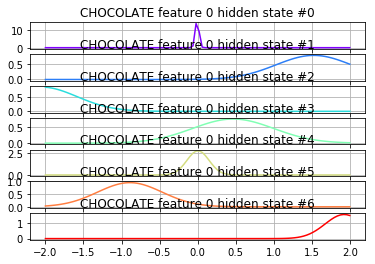

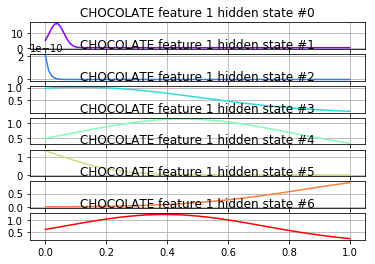

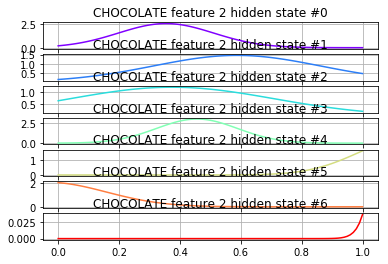

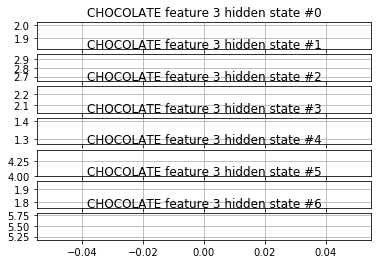

In [41]:
import math
from matplotlib import (cm, pyplot as plt, mlab)

def visualize(word, model):
    """ visualize the input model for a particular word """
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])
    figures = []
    for parm_idx in range(len(model.means_[0])):
        xmin = int(min(model.means_[:,parm_idx]) - max(variance[:,parm_idx]))
        xmax = int(max(model.means_[:,parm_idx]) + max(variance[:,parm_idx]))
        fig, axs = plt.subplots(model.n_components, sharex=True, sharey=False)
        colours = cm.rainbow(np.linspace(0, 1, model.n_components))
        for i, (ax, colour) in enumerate(zip(axs, colours)):
            x = np.linspace(xmin, xmax, 100)
            mu = model.means_[i,parm_idx]
            sigma = math.sqrt(np.diag(model.covars_[i])[parm_idx])
            ax.plot(x, mlab.normpdf(x, mu, sigma), c=colour)
            ax.set_title("{} feature {} hidden state #{}".format(word, parm_idx, i))

            ax.grid(True)
        figures.append(plt)
    for p in figures:
        p.show()
        
visualize(my_testword, model)

#####  ModelSelector class
Review the `ModelSelector` class from the codebase found in the `my_model_selectors.py` module.  It is designed to be a strategy pattern for choosing different model selectors.  For the project submission in this section, subclass `SelectorModel` to implement the following model selectors.  In other words, you will write your own classes/functions in the `my_model_selectors.py` module and run them from this notebook:

- `SelectorCV `:  Log likelihood with CV
- `SelectorBIC`: BIC 
- `SelectorDIC`: DIC

You will train each word in the training set with a range of values for the number of hidden states, and then score these alternatives with the model selector, choosing the "best" according to each strategy. The simple case of training with a constant value for `n_components` can be called using the provided `SelectorConstant` subclass as follow:

In [42]:
from my_model_selectors import SelectorConstant

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
word = 'VEGETABLE' # Experiment here with different words
model = SelectorConstant(training.get_all_sequences(), training.get_all_Xlengths(), word, n_constant=3).select()
print("Number of states trained in model for {} is {}".format(word, model.n_components))

Number of states trained in model for VEGETABLE is 3


##### Cross-validation folds
If we simply score the model with the Log Likelihood calculated from the feature sequences it has been trained on, we should expect that more complex models will have higher likelihoods. However, that doesn't tell us which would have a better likelihood score on unseen data.  The model will likely be overfit as complexity is added.  To estimate which topology model is better using only the training data, we can compare scores using cross-validation.  One technique for cross-validation is to break the training set into "folds" and rotate which fold is left out of training.  The "left out" fold scored.  This gives us a proxy method of finding the best model to use on "unseen data". In the following example, a set of word sequences is broken into three folds using the [scikit-learn Kfold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) class object. When you implement `SelectorCV`, you will use this technique.

In [14]:
from sklearn.model_selection import KFold

training = asl.build_training(features_ground) # Experiment here with different feature sets
word = 'FISH' # Experiment here with different words
word_sequences = training.get_word_sequences(word)
split_method = KFold()
for cv_train_idx, cv_test_idx in split_method.split(word_sequences):
    print("Train fold indices:{} Test fold indices:{}".format(cv_train_idx, cv_test_idx))  # view indices of the folds

ValueError: Cannot have number of splits n_splits=3 greater than the number of samples: 2.

**Tip:** In order to run `hmmlearn` training using the X,lengths tuples on the new folds, subsets must be combined based on the indices given for the folds.  A helper utility has been provided in the `asl_utils` module named `combine_sequences` for this purpose.

##### Scoring models with other criterion
Scoring model topologies with **BIC** balances fit and complexity within the training set for each word.  In the BIC equation, a penalty term penalizes complexity to avoid overfitting, so that it is not necessary to also use cross-validation in the selection process.  There are a number of references on the internet for this criterion.  These [slides](http://www2.imm.dtu.dk/courses/02433/doc/ch6_slides.pdf) include a formula you may find helpful for your implementation.

The advantages of scoring model topologies with **DIC** over BIC are presented by Alain Biem in this [reference](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.58.6208&rep=rep1&type=pdf) (also found [here](https://pdfs.semanticscholar.org/ed3d/7c4a5f607201f3848d4c02dd9ba17c791fc2.pdf)).  DIC scores the discriminant ability of a training set for one word against competing words.  Instead of a penalty term for complexity, it provides a penalty if model liklihoods for non-matching words are too similar to model likelihoods for the correct word in the word set.

<a id='part2_submission'></a>
### Model Selection Implementation Submission
Implement `SelectorCV`, `SelectorBIC`, and `SelectorDIC` classes in the `my_model_selectors.py` module.  Run the selectors on the following five words. Then answer the questions about your results.

**Tip:** The `hmmlearn` library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [115]:
words_to_train = ['FISH', 'BOOK', 'VEGETABLE', 'FUTURE', 'JOHN']
#words_to_train = ['VEGETABLE']
import timeit

In [127]:
# features_custom = ['norm-delta-rx', 'norm-delta-ry', 'norm-delta-lx', 'norm-delta-ry',
#                   'norm-grnd-rx', 'norm-grnd-ry', 'norm-grnd-lx', 'norm-grnd-ly']

features_custom = ['norm-polar-rr', 'norm-polar-rtheta', 'norm-polar-lr', 'norm-polar-ltheta']

training = asl.build_training(features_custom)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()

ERROR:root:12 hidden states: 14, word: FISH
Traceback (most recent call last):
  File "/Users/oboiko/Development/aind/AIND-Recognizer/my_model_selectors.py", line 180, in select
    model = self.base_model(num_hidden_states).fit(X_train, lengths_train)
  File "/Users/oboiko/anaconda3/lib/python3.6/site-packages/hmmlearn/base.py", line 421, in fit
    self._init(X, lengths=lengths)
  File "/Users/oboiko/anaconda3/lib/python3.6/site-packages/hmmlearn/hmm.py", line 189, in _init
    kmeans.fit(X)
  File "/Users/oboiko/anaconda3/lib/python3.6/site-packages/sklearn/cluster/k_means_.py", line 880, in fit
    X = self._check_fit_data(X)
  File "/Users/oboiko/anaconda3/lib/python3.6/site-packages/sklearn/cluster/k_means_.py", line 857, in _check_fit_data
    X.shape[0], self.n_clusters))
ValueError: n_samples=13 should be >= n_clusters=14
ERROR:root:12 hidden states: 15, word: FISH
Traceback (most recent call last):
  File "/Users/oboiko/Development/aind/AIND-Recognizer/my_model_selectors.py",

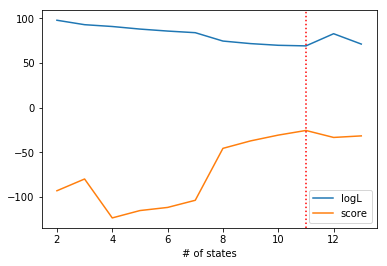

Training complete for FISH with 11 states with time 1.2614391800016165 seconds


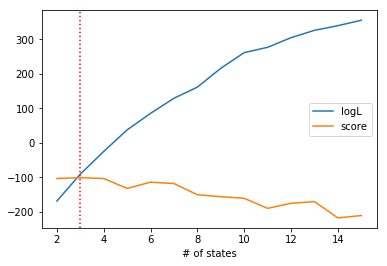

Training complete for BOOK with 3 states with time 18.65070899197599 seconds


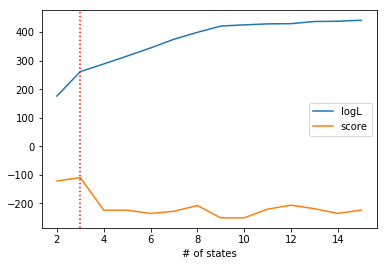

Training complete for VEGETABLE with 3 states with time 9.096970075974241 seconds


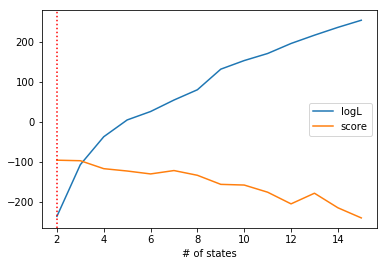

Training complete for FUTURE with 2 states with time 19.025120984995738 seconds


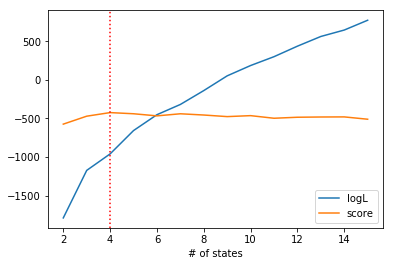

Training complete for JOHN with 4 states with time 190.49062087998027 seconds


In [128]:
from my_model_selectors import SelectorCV

for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorCV(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

FISH has 2 sequences


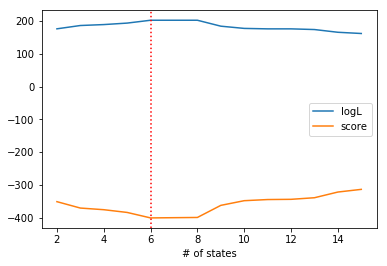

Training complete for FISH with 6 states with time 1.011649482010398 seconds
BOOK has 18 sequences


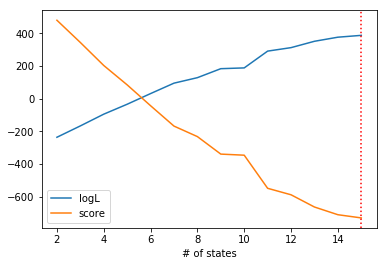

Training complete for BOOK with 15 states with time 4.7696412410005 seconds
VEGETABLE has 6 sequences


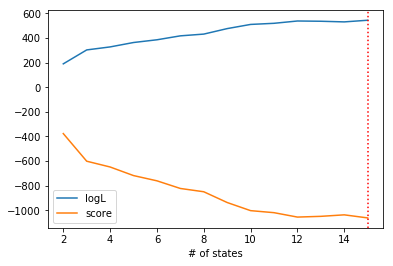

Training complete for VEGETABLE with 15 states with time 1.5623891730210744 seconds
FUTURE has 15 sequences


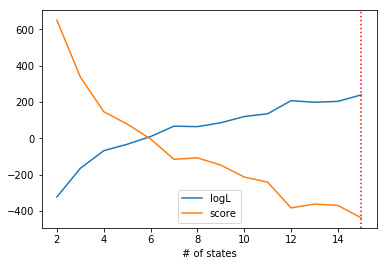

Training complete for FUTURE with 15 states with time 5.049158986017574 seconds
JOHN has 113 sequences


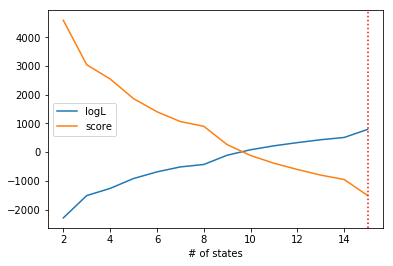

Training complete for JOHN with 15 states with time 44.5752973970375 seconds


In [129]:
from my_model_selectors import SelectorBIC

for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorBIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

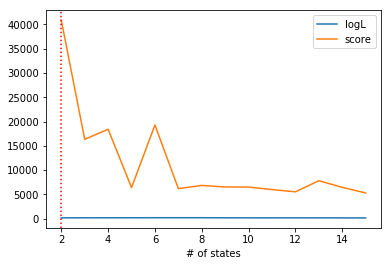

Training complete for FISH with 2 states with time 3.299495833052788 seconds


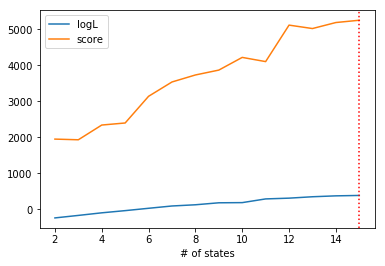

Training complete for BOOK with 15 states with time 6.037365819036495 seconds


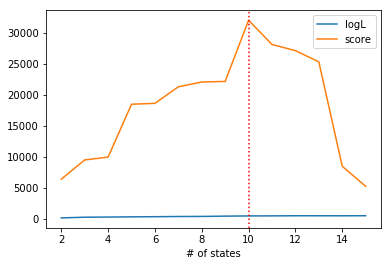

Training complete for VEGETABLE with 10 states with time 3.517384904960636 seconds


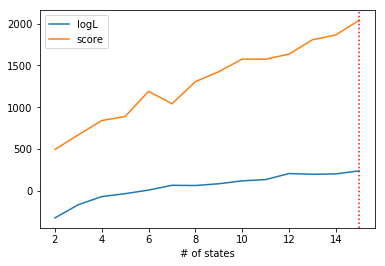

Training complete for FUTURE with 15 states with time 6.419245175027754 seconds


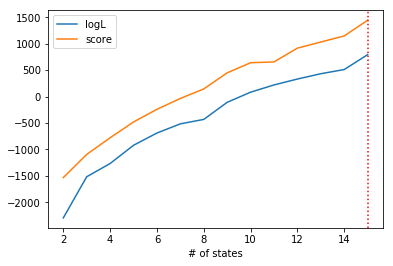

Training complete for JOHN with 15 states with time 48.14243859302951 seconds


In [130]:
from my_model_selectors import SelectorDIC

for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorDIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

**Question 2:**  Compare and contrast the possible advantages and disadvantages of the various model selectors implemented.

**Answer 2:**
* CV method produced similar results for 3 and 5 folds.
* The most difference between "score" and "logL" curves appears in CV selector, which can be explained by the fact that Train set and CV set are completely different.
* CV selector is more sensitive to the amount of data. It requires more data to produce accurate results, because actual training is done only on a subset of data, leaving CV subset aside.
* With BIC selector, "score" and "logL" curves are very similar (mirror-reflected, because formula uses -2\*logL). "score" curve is "sharper" than "logL" curve because of the character of the formula, i.e. the bigger number of states the bigger the "penalty". Otherwise graphs show that BIC score is mainly "driven" by logL, meaning num_states(max(logL)) == num_states(min(bic_score)). This result might be different given more data points, or trying more states
* BIC tends to overfit
* DIC selector is the most interesting because it actually accounts for how well trained model fits other words. It aims at finding a model which has lowest chance to confuse one sign with the other.
* DIC score doesn't follow logL curve as close as BIC score, this is illustrated prominently at "VEGETABLE" graph
* Trying two different feature sets showed that results are roughly the same for all but "VEGETABLE" for DIC, which jumped from 3 to 10 states.


<a id='part2_test'></a>
### Model Selector Unit Testing
Run the following unit tests as a sanity check on the implemented model selectors.  The test simply looks for valid interfaces  but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [131]:
from asl_test_model_selectors import TestSelectors
suite = unittest.TestLoader().loadTestsFromModule(TestSelectors())
unittest.TextTestRunner().run(suite)

E.EE
ERROR: test_select_bic_interface (asl_test_model_selectors.TestSelectors)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/Users/oboiko/Development/aind/AIND-Recognizer/asl_test_model_selectors.py", line 24, in test_select_bic_interface
    model = SelectorBIC(self.sequences, self.xlengths, 'FRANK').select()
  File "/Users/oboiko/Development/aind/AIND-Recognizer/my_model_selectors.py", line 101, in select
    results = self.init_results()
AttributeError: 'SelectorBIC' object has no attribute 'init_results'

ERROR: test_select_cv_interface (asl_test_model_selectors.TestSelectors)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/Users/oboiko/Development/aind/AIND-Recognizer/asl_test_model_selectors.py", line 30, in test_select_cv_interface
    model = SelectorCV(self.sequences, self.xlengths, 'JOHN').select()
  File "/Users/oboiko/Development/aind/AIND-

<unittest.runner.TextTestResult run=4 errors=3 failures=0>

<a id='part3_tutorial'></a>
## PART 3: Recognizer
The objective of this section is to "put it all together".  Using the four feature sets created and the three model selectors, you will experiment with the models and present your results.  Instead of training only five specific words as in the previous section, train the entire set with a feature set and model selector strategy.  
### Recognizer Tutorial
##### Train the full training set
The following example trains the entire set with the example `features_ground` and `SelectorConstant` features and model selector.  Use this pattern for you experimentation and final submission cells.



In [133]:
# autoreload for automatically reloading changes made in my_model_selectors and my_recognizer
%load_ext autoreload
%autoreload 2

from my_model_selectors import SelectorConstant

def train_all_words(features, model_selector):
    training = asl.build_training(features)  # Experiment here with different feature sets defined in part 1
    sequences = training.get_all_sequences()
    Xlengths = training.get_all_Xlengths()
    model_dict = {}
    for word in training.words:
        model = model_selector(sequences, Xlengths, word, 
                        n_constant=3).select()
        model_dict[word]=model
    return model_dict

models = train_all_words(features_ground, SelectorConstant)
print("Number of word models returned = {}".format(len(models)))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Number of word models returned = 112


##### Load the test set
The `build_test` method in `ASLdb` is similar to the `build_training` method already presented, but there are a few differences:
- the object is type `SinglesData` 
- the internal dictionary keys are the index of the test word rather than the word itself
- the getter methods are `get_all_sequences`, `get_all_Xlengths`, `get_item_sequences` and `get_item_Xlengths`

In [168]:
test_set = asl.build_test(features_custom)
print("Number of test set items: {}".format(test_set.num_items))
print("Number of test set sentences: {}".format(len(test_set.sentences_index)))

Number of test set items: 178
Number of test set sentences: 40


<a id='part3_submission'></a>
### Recognizer Implementation Submission
For the final project submission, students must implement a recognizer following guidance in the `my_recognizer.py` module.  Experiment with the four feature sets and the three model selection methods (that's 12 possible combinations). You can add and remove cells for experimentation or run the recognizers locally in some other way during your experiments, but retain the results for your discussion.  For submission, you will provide code cells of **only three** interesting combinations for your discussion (see questions below). At least one of these should produce a word error rate of less than 60%, i.e. WER < 0.60 . 

**Tip:** The hmmlearn library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [135]:
# TODO implement the recognize method in my_recognizer
from my_recognizer import recognize
from asl_utils import show_errors

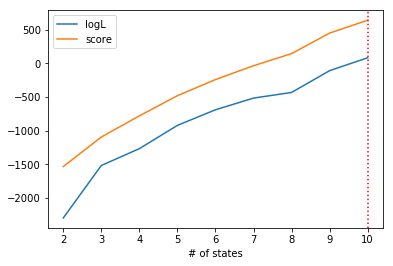

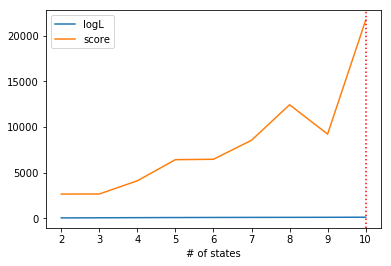

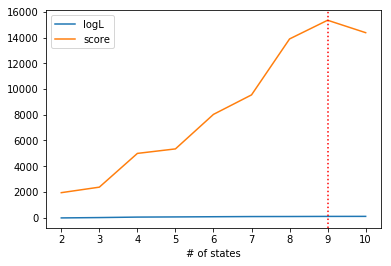

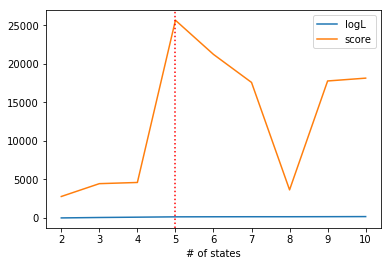

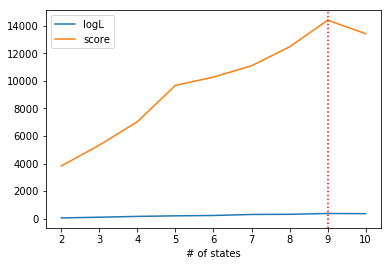

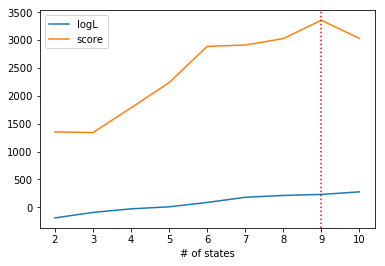

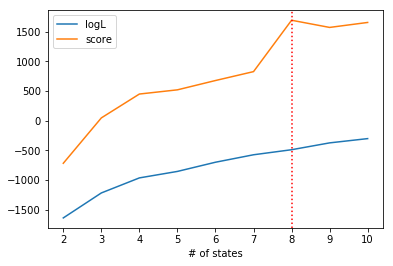

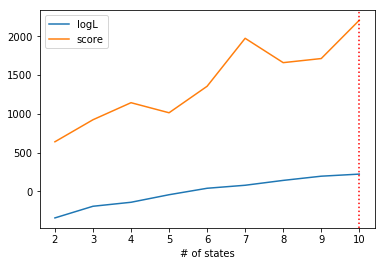

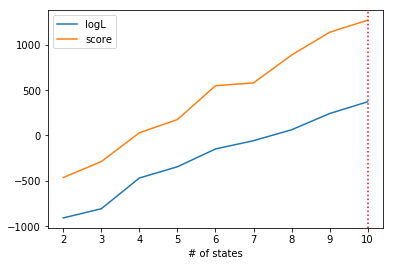

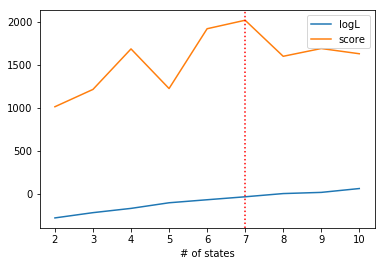

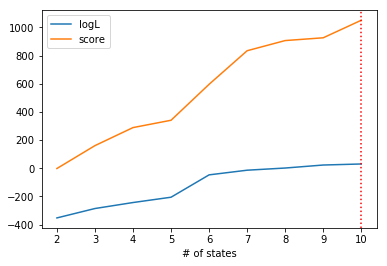

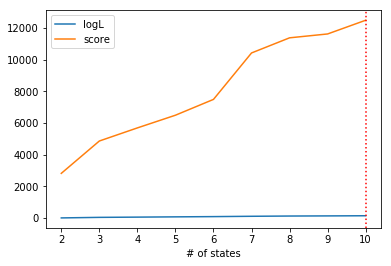

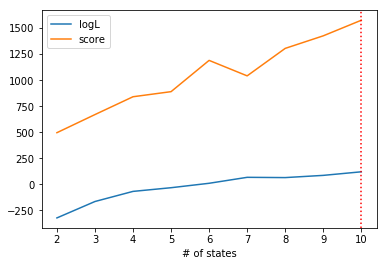

ERROR:root:0 hidden states: 7, word: GO2
Traceback (most recent call last):
  File "/Users/oboiko/Development/aind/AIND-Recognizer/my_model_selectors.py", line 139, in select
    model = self.base_model(num_hidden_states).fit(self.X, self.lengths)
AttributeError: 'NoneType' object has no attribute 'fit'
ERROR:root:0 hidden states: 8, word: GO2
Traceback (most recent call last):
  File "/Users/oboiko/Development/aind/AIND-Recognizer/my_model_selectors.py", line 139, in select
    model = self.base_model(num_hidden_states).fit(self.X, self.lengths)
AttributeError: 'NoneType' object has no attribute 'fit'
ERROR:root:0 hidden states: 9, word: GO2
Traceback (most recent call last):
  File "/Users/oboiko/Development/aind/AIND-Recognizer/my_model_selectors.py", line 139, in select
    model = self.base_model(num_hidden_states).fit(self.X, self.lengths)
AttributeError: 'NoneType' object has no attribute 'fit'
ERROR:root:0 hidden states: 10, word: GO2
Traceback (most recent call last):
  File "

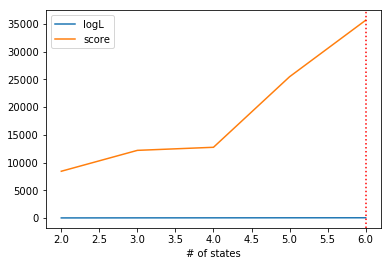

ERROR:root:0 hidden states: 10, word: PARTY
Traceback (most recent call last):
  File "/Users/oboiko/Development/aind/AIND-Recognizer/my_model_selectors.py", line 139, in select
    model = self.base_model(num_hidden_states).fit(self.X, self.lengths)
AttributeError: 'NoneType' object has no attribute 'fit'


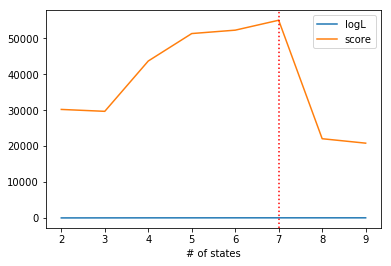

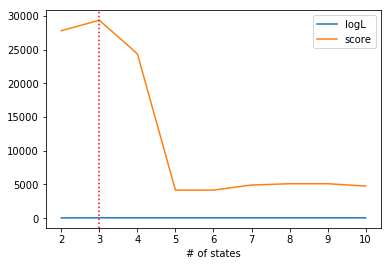

ERROR:root:0 hidden states: 10, word: HIT
Traceback (most recent call last):
  File "/Users/oboiko/Development/aind/AIND-Recognizer/my_model_selectors.py", line 139, in select
    model = self.base_model(num_hidden_states).fit(self.X, self.lengths)
AttributeError: 'NoneType' object has no attribute 'fit'


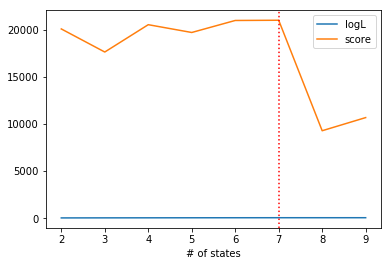

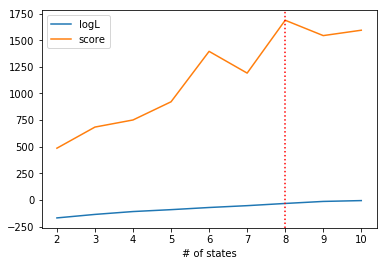

ERROR:root:0 hidden states: 10, word: FRED
Traceback (most recent call last):
  File "/Users/oboiko/Development/aind/AIND-Recognizer/my_model_selectors.py", line 139, in select
    model = self.base_model(num_hidden_states).fit(self.X, self.lengths)
AttributeError: 'NoneType' object has no attribute 'fit'


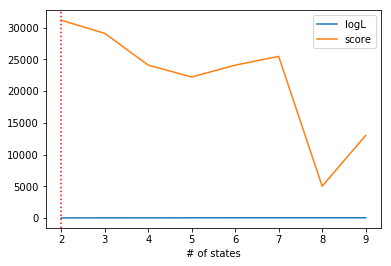

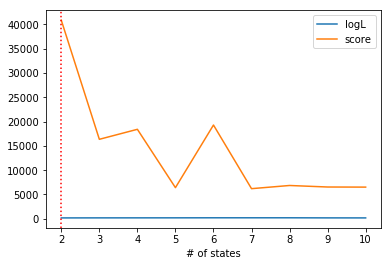

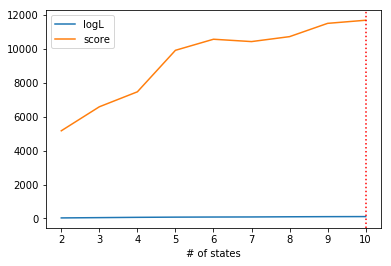

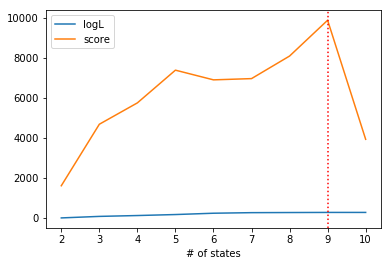

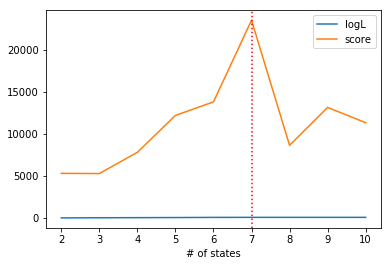

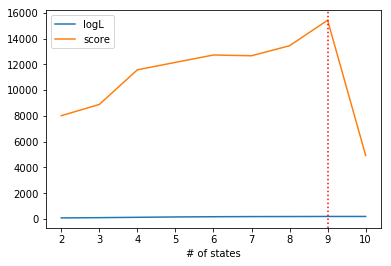

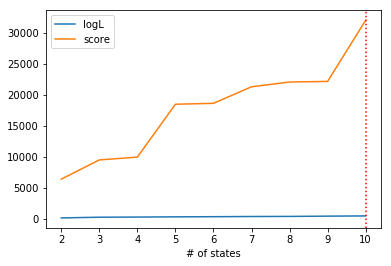

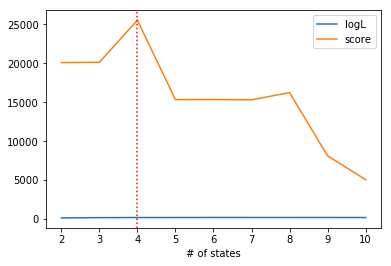

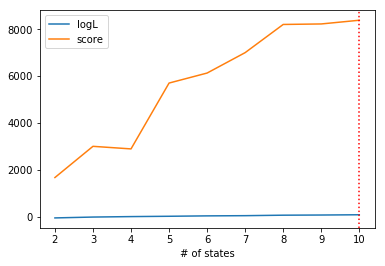

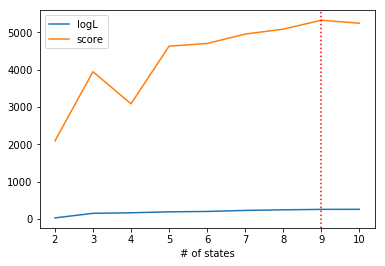

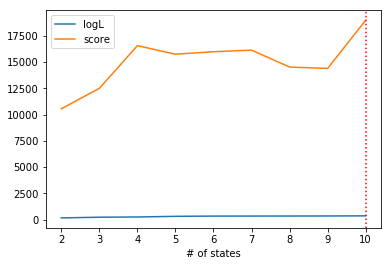

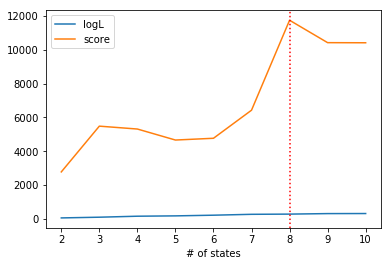

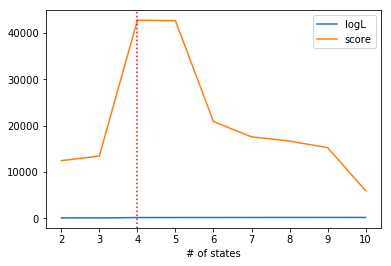

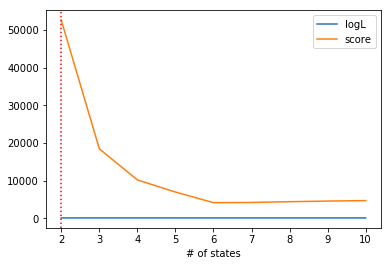

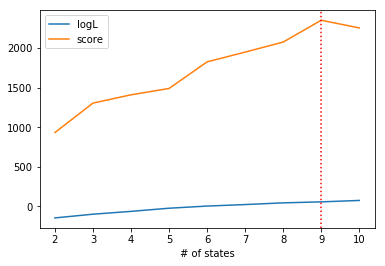

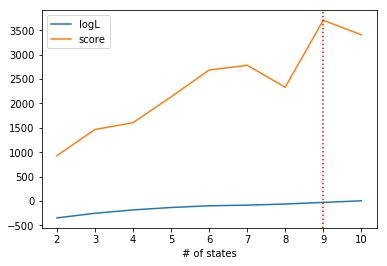

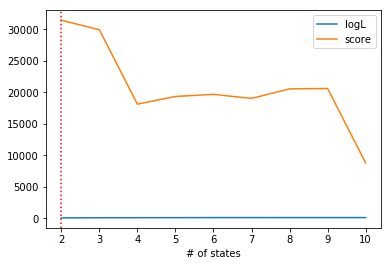

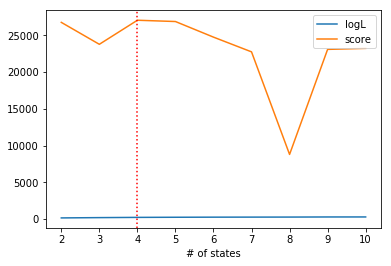

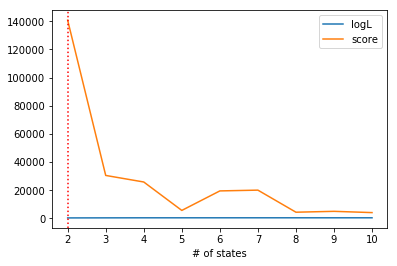

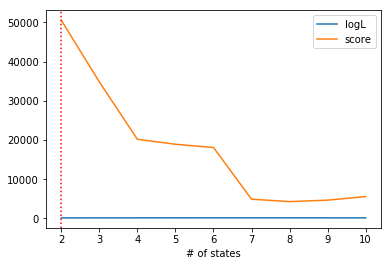

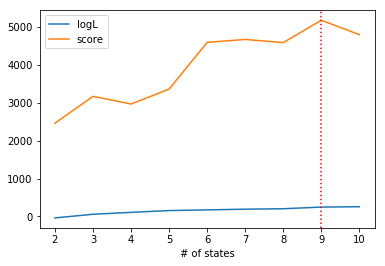

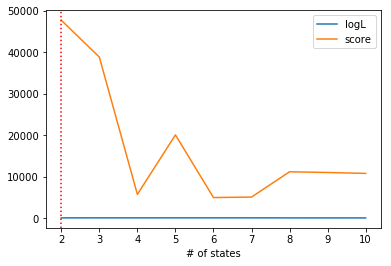

ERROR:root:0 hidden states: 7, word: LIVE
Traceback (most recent call last):
  File "/Users/oboiko/Development/aind/AIND-Recognizer/my_model_selectors.py", line 139, in select
    model = self.base_model(num_hidden_states).fit(self.X, self.lengths)
AttributeError: 'NoneType' object has no attribute 'fit'
ERROR:root:0 hidden states: 8, word: LIVE
Traceback (most recent call last):
  File "/Users/oboiko/Development/aind/AIND-Recognizer/my_model_selectors.py", line 139, in select
    model = self.base_model(num_hidden_states).fit(self.X, self.lengths)
AttributeError: 'NoneType' object has no attribute 'fit'
ERROR:root:0 hidden states: 9, word: LIVE
Traceback (most recent call last):
  File "/Users/oboiko/Development/aind/AIND-Recognizer/my_model_selectors.py", line 139, in select
    model = self.base_model(num_hidden_states).fit(self.X, self.lengths)
AttributeError: 'NoneType' object has no attribute 'fit'
ERROR:root:0 hidden states: 10, word: LIVE
Traceback (most recent call last):
  Fi

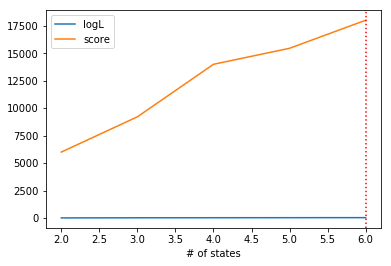

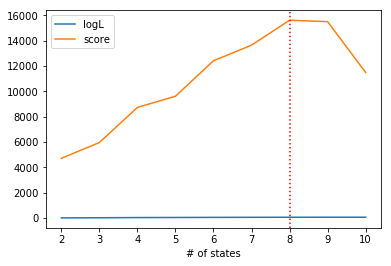

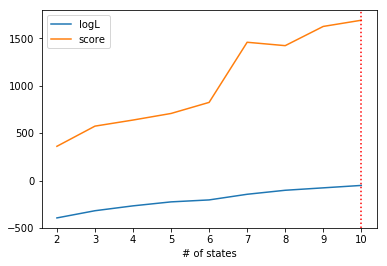

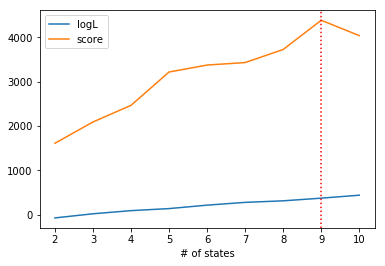

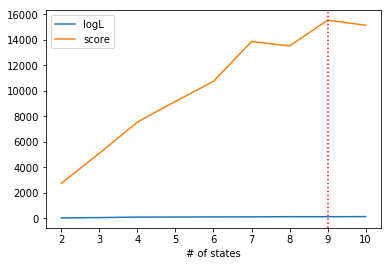

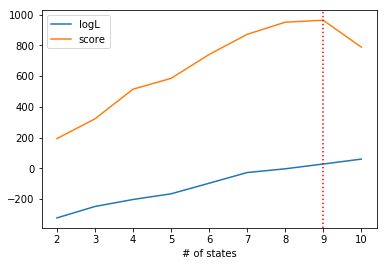

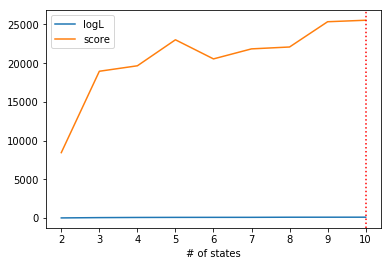

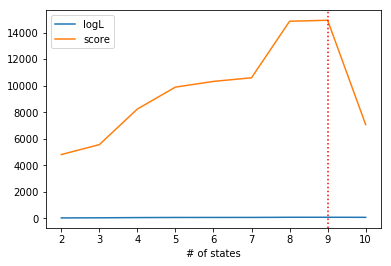

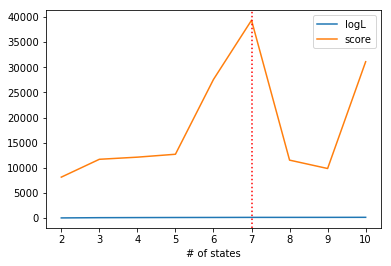

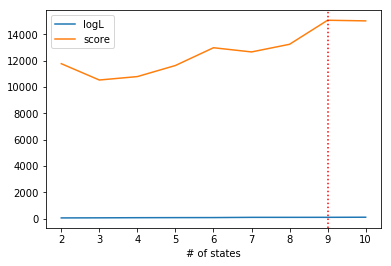

ERROR:root:0 hidden states: 8, word: NEXT-WEEK
Traceback (most recent call last):
  File "/Users/oboiko/Development/aind/AIND-Recognizer/my_model_selectors.py", line 139, in select
    model = self.base_model(num_hidden_states).fit(self.X, self.lengths)
AttributeError: 'NoneType' object has no attribute 'fit'
ERROR:root:0 hidden states: 9, word: NEXT-WEEK
Traceback (most recent call last):
  File "/Users/oboiko/Development/aind/AIND-Recognizer/my_model_selectors.py", line 139, in select
    model = self.base_model(num_hidden_states).fit(self.X, self.lengths)
AttributeError: 'NoneType' object has no attribute 'fit'
ERROR:root:0 hidden states: 10, word: NEXT-WEEK
Traceback (most recent call last):
  File "/Users/oboiko/Development/aind/AIND-Recognizer/my_model_selectors.py", line 139, in select
    model = self.base_model(num_hidden_states).fit(self.X, self.lengths)
AttributeError: 'NoneType' object has no attribute 'fit'


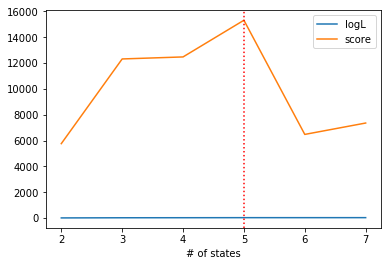

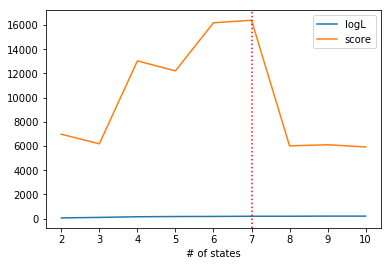

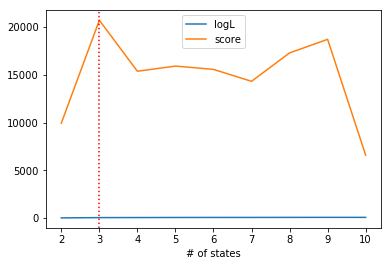

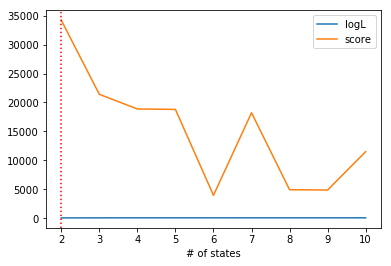

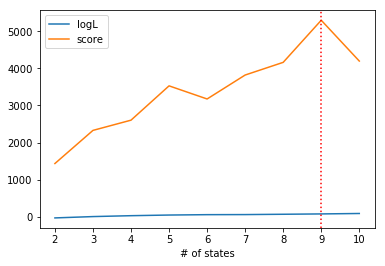

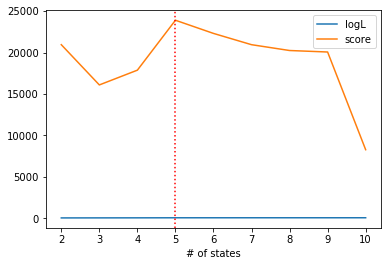

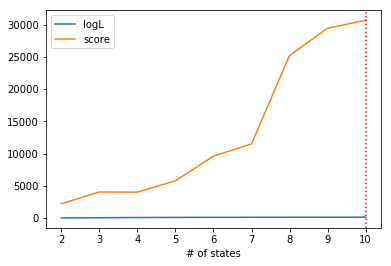

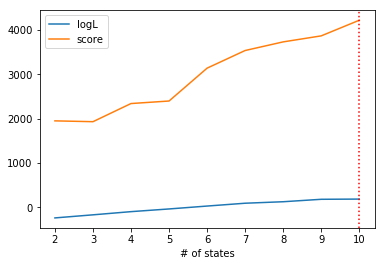

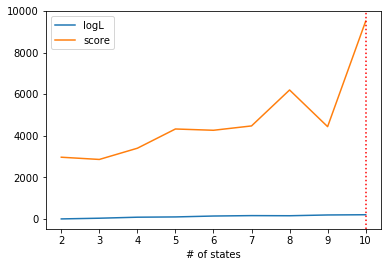

ERROR:root:0 hidden states: 5, word: FIND
Traceback (most recent call last):
  File "/Users/oboiko/Development/aind/AIND-Recognizer/my_model_selectors.py", line 139, in select
    model = self.base_model(num_hidden_states).fit(self.X, self.lengths)
AttributeError: 'NoneType' object has no attribute 'fit'
ERROR:root:0 hidden states: 6, word: FIND
Traceback (most recent call last):
  File "/Users/oboiko/Development/aind/AIND-Recognizer/my_model_selectors.py", line 139, in select
    model = self.base_model(num_hidden_states).fit(self.X, self.lengths)
AttributeError: 'NoneType' object has no attribute 'fit'
ERROR:root:0 hidden states: 7, word: FIND
Traceback (most recent call last):
  File "/Users/oboiko/Development/aind/AIND-Recognizer/my_model_selectors.py", line 139, in select
    model = self.base_model(num_hidden_states).fit(self.X, self.lengths)
AttributeError: 'NoneType' object has no attribute 'fit'
ERROR:root:0 hidden states: 8, word: FIND
Traceback (most recent call last):
  Fil

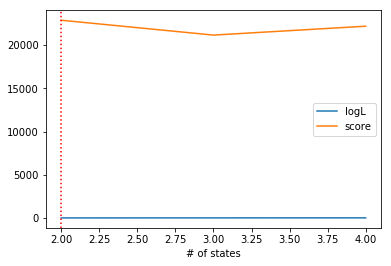

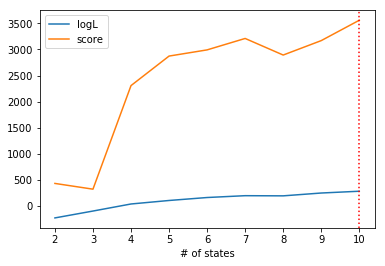

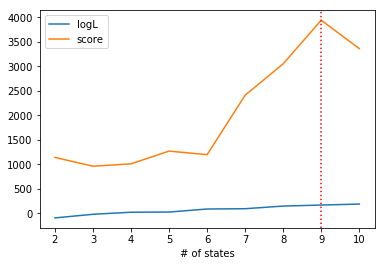

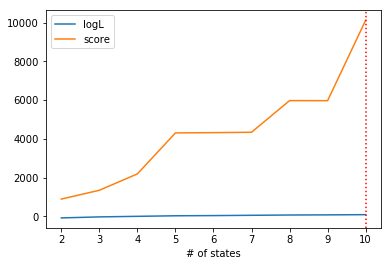

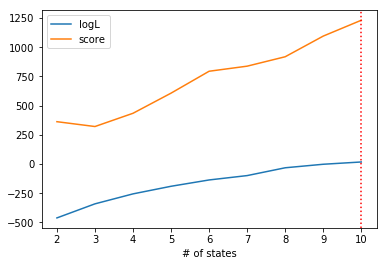

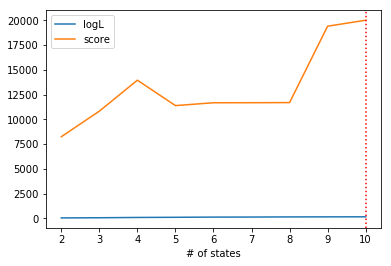

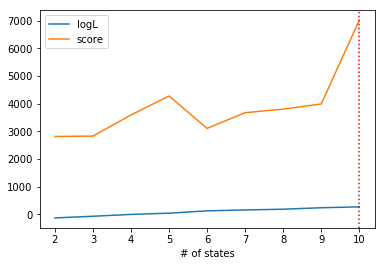

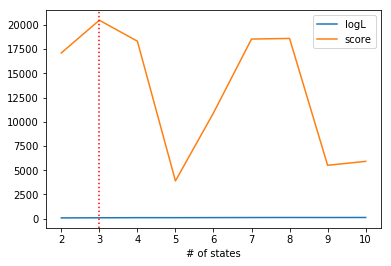

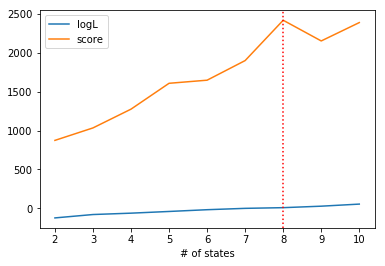

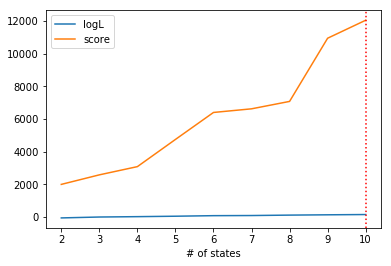

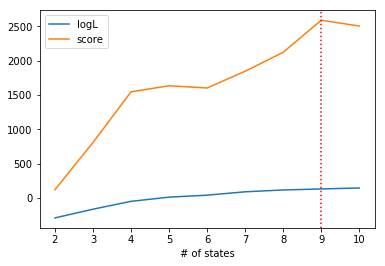

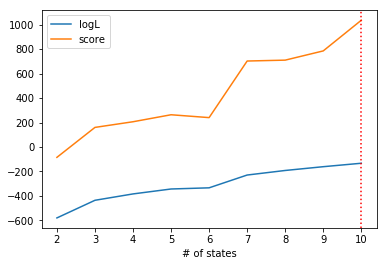

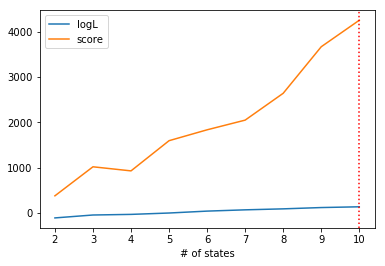

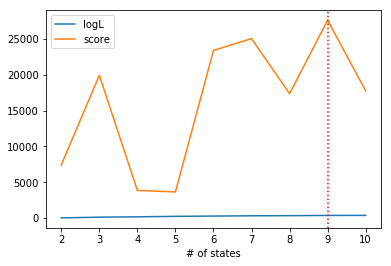

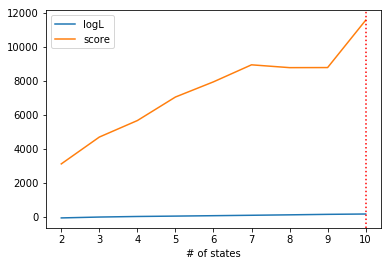

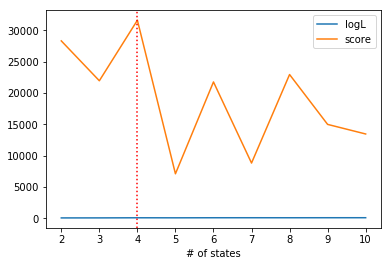

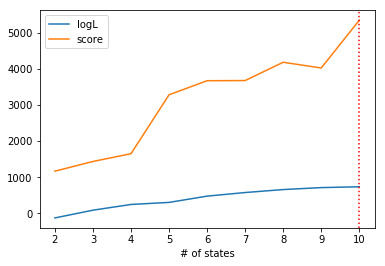

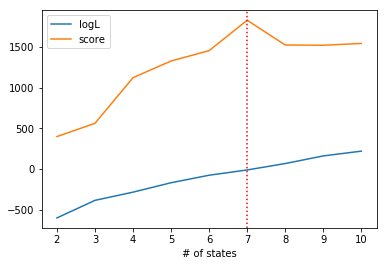

ERROR:root:0 hidden states: 9, word: LEG
Traceback (most recent call last):
  File "/Users/oboiko/Development/aind/AIND-Recognizer/my_model_selectors.py", line 139, in select
    model = self.base_model(num_hidden_states).fit(self.X, self.lengths)
AttributeError: 'NoneType' object has no attribute 'fit'
ERROR:root:0 hidden states: 10, word: LEG
Traceback (most recent call last):
  File "/Users/oboiko/Development/aind/AIND-Recognizer/my_model_selectors.py", line 139, in select
    model = self.base_model(num_hidden_states).fit(self.X, self.lengths)
AttributeError: 'NoneType' object has no attribute 'fit'


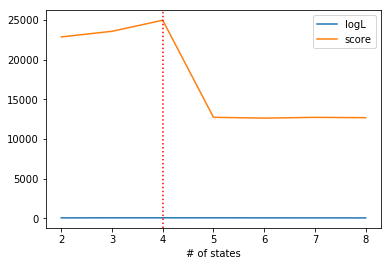

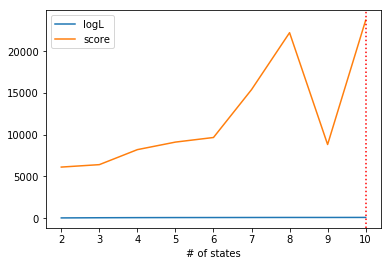

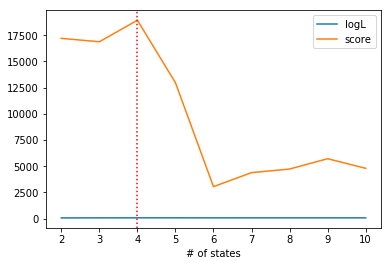

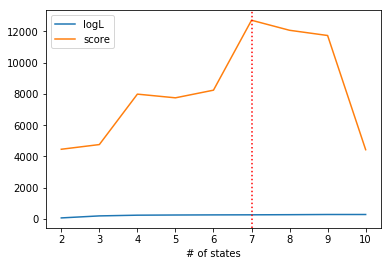

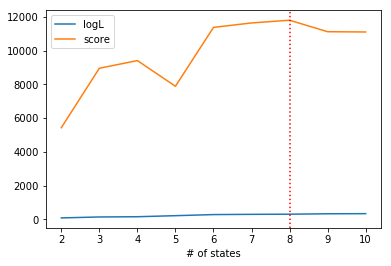

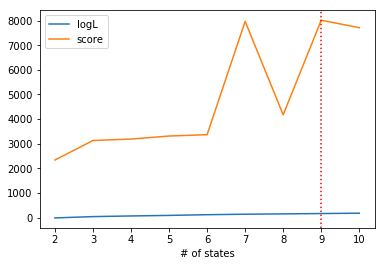

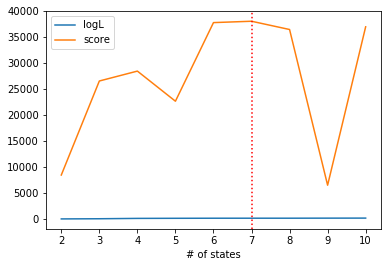

ERROR:root:0 hidden states: 10, word: OLD
Traceback (most recent call last):
  File "/Users/oboiko/Development/aind/AIND-Recognizer/my_model_selectors.py", line 139, in select
    model = self.base_model(num_hidden_states)
AttributeError: 'NoneType' object has no attribute 'fit'


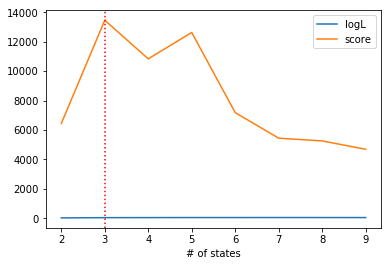

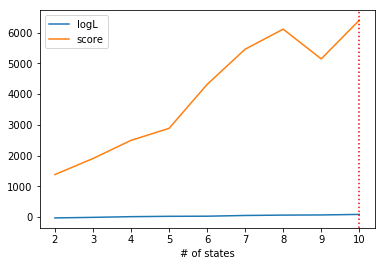

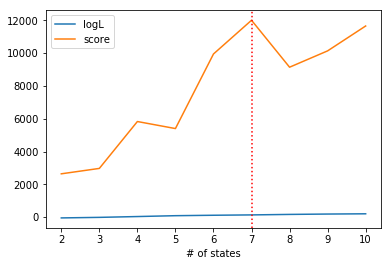

ERROR:root:0 hidden states: 7, word: BORROW
Traceback (most recent call last):
  File "/Users/oboiko/Development/aind/AIND-Recognizer/my_model_selectors.py", line 139, in select
    model = self.base_model(num_hidden_states)
AttributeError: 'NoneType' object has no attribute 'fit'
ERROR:root:0 hidden states: 8, word: BORROW
Traceback (most recent call last):
  File "/Users/oboiko/Development/aind/AIND-Recognizer/my_model_selectors.py", line 139, in select
    model = self.base_model(num_hidden_states)
AttributeError: 'NoneType' object has no attribute 'fit'
ERROR:root:0 hidden states: 9, word: BORROW
Traceback (most recent call last):
  File "/Users/oboiko/Development/aind/AIND-Recognizer/my_model_selectors.py", line 139, in select
    model = self.base_model(num_hidden_states)
AttributeError: 'NoneType' object has no attribute 'fit'
ERROR:root:0 hidden states: 10, word: BORROW
Traceback (most recent call last):
  File "/Users/oboiko/Development/aind/AIND-Recognizer/my_model_selectors.

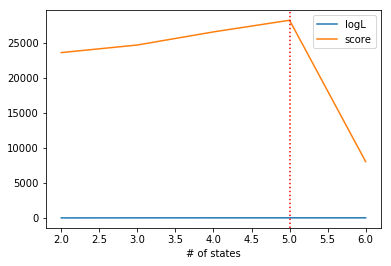

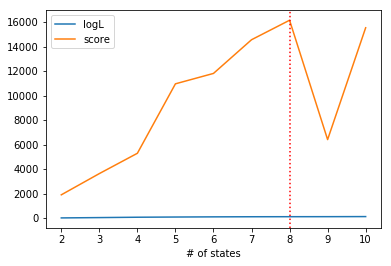

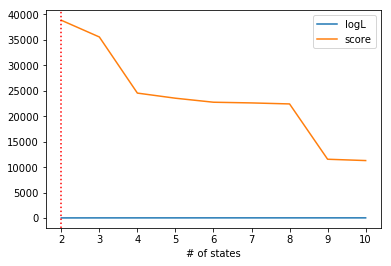

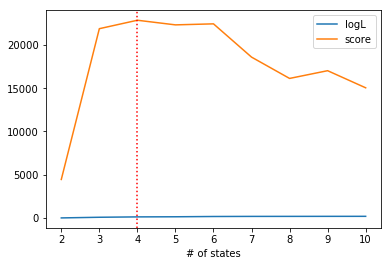

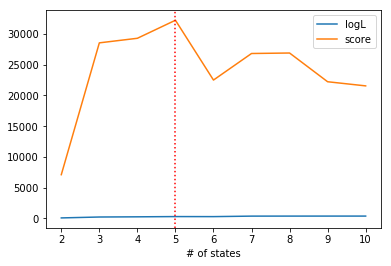

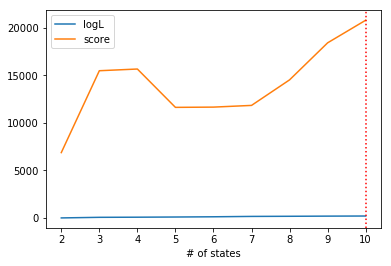

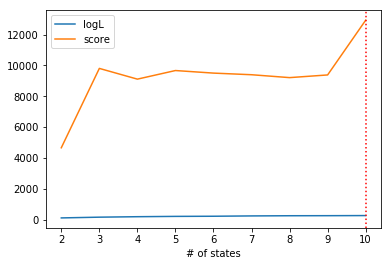

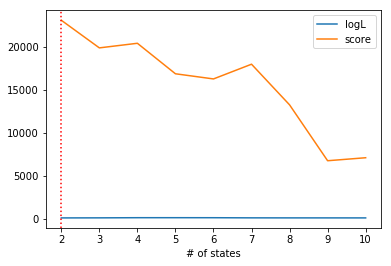

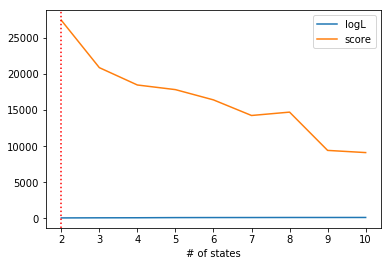

ERROR:root:0 hidden states: 9, word: SAY-1P
Traceback (most recent call last):
  File "/Users/oboiko/Development/aind/AIND-Recognizer/my_model_selectors.py", line 139, in select
    model = self.base_model(num_hidden_states)
AttributeError: 'NoneType' object has no attribute 'fit'
ERROR:root:0 hidden states: 10, word: SAY-1P
Traceback (most recent call last):
  File "/Users/oboiko/Development/aind/AIND-Recognizer/my_model_selectors.py", line 139, in select
    model = self.base_model(num_hidden_states)
AttributeError: 'NoneType' object has no attribute 'fit'


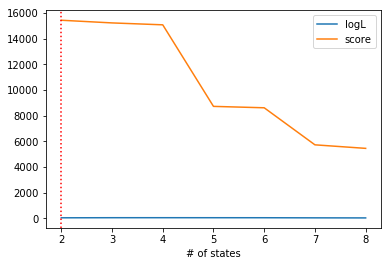

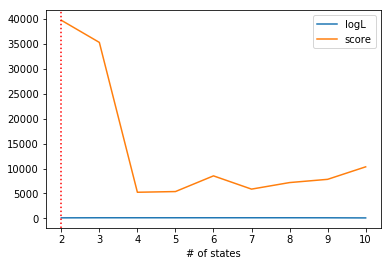

ERROR:root:0 hidden states: 10, word: GROUP
Traceback (most recent call last):
  File "/Users/oboiko/Development/aind/AIND-Recognizer/my_model_selectors.py", line 139, in select
    model = self.base_model(num_hidden_states)
AttributeError: 'NoneType' object has no attribute 'fit'


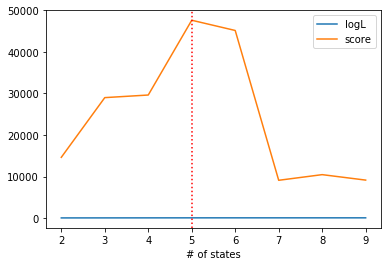

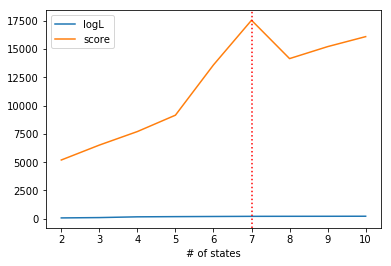

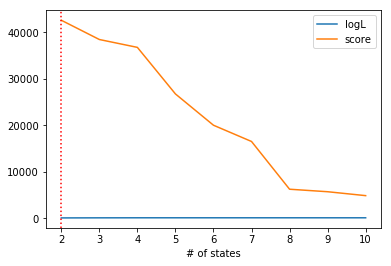

ERROR:root:0 hidden states: 10, word: MANY
Traceback (most recent call last):
  File "/Users/oboiko/Development/aind/AIND-Recognizer/my_model_selectors.py", line 139, in select
    model = self.base_model(num_hidden_states)
AttributeError: 'NoneType' object has no attribute 'fit'


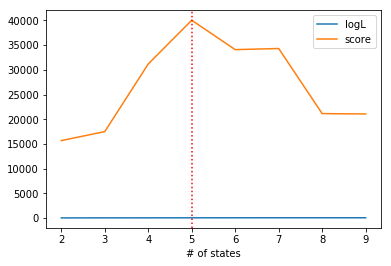

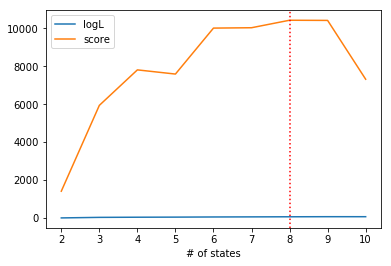

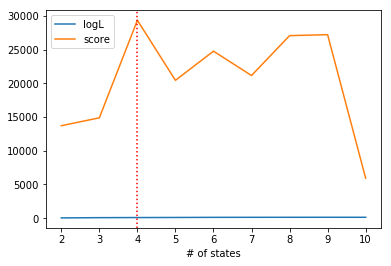

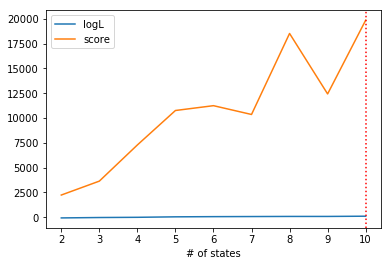

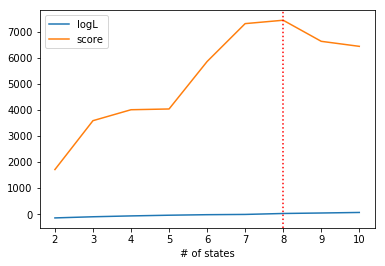

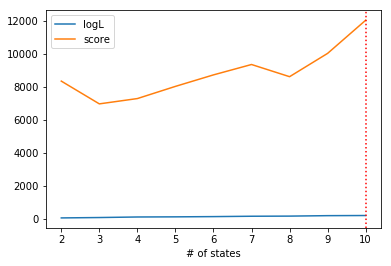

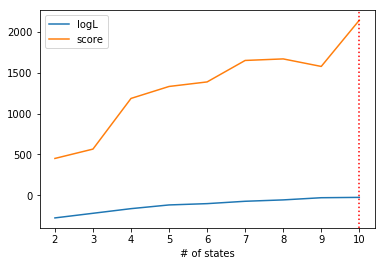

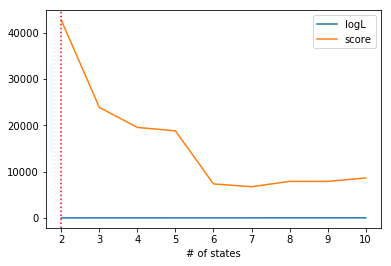

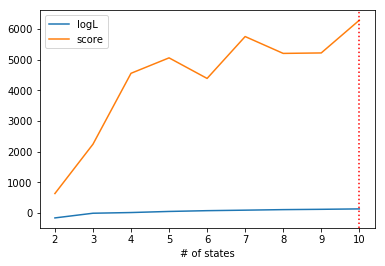

ERROR:root:0 hidden states: 9, word: GET
Traceback (most recent call last):
  File "/Users/oboiko/Development/aind/AIND-Recognizer/my_model_selectors.py", line 139, in select
    model = self.base_model(num_hidden_states)
AttributeError: 'NoneType' object has no attribute 'fit'
ERROR:root:0 hidden states: 10, word: GET
Traceback (most recent call last):
  File "/Users/oboiko/Development/aind/AIND-Recognizer/my_model_selectors.py", line 139, in select
    model = self.base_model(num_hidden_states)
AttributeError: 'NoneType' object has no attribute 'fit'


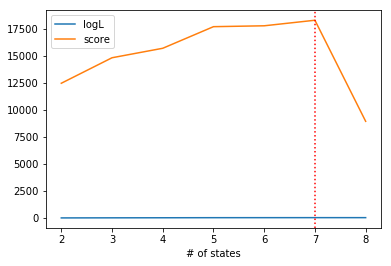

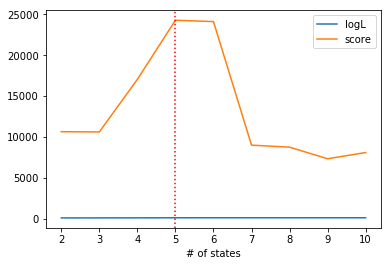

In [169]:
# TODO Choose a feature set and model selector
features = features_custom # change as needed
model_selector = SelectorDIC # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)

In [167]:
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.6741573033707865
Total correct: 58 out of 178
Video  Recognized                                                    Correct
    2: *GO *BOOK *ARRIVE                                             JOHN WRITE HOMEWORK
    7: *SOMETHING-ONE *GO1 *IX CAN                                   JOHN CAN GO CAN
   12: JOHN *HAVE *WHAT CAN                                          JOHN CAN GO CAN
   21: JOHN *HOMEWORK *NEW *PREFER *CAR *CAR *FUTURE *EAT            JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: *FRANK *TELL *LOVE *TELL *LOVE                                JOHN LIKE IX IX IX
   28: *FRANK *TELL *LOVE *TELL *LOVE                                JOHN LIKE IX IX IX
   30: *SHOULD LIKE *GO *GO *GO                                      JOHN LIKE IX IX IX
   36: *VISIT VEGETABLE *YESTERDAY *GIVE *MARY *MARY                 MARY VEGETABLE KNOW IX LIKE CORN1
   40: *SUE *GIVE *CORN *VEGETABLE *GO                               JOHN IX THINK MARY LOVE
   43: *FRANK *GO BUY HOUSE         

In [ ]:
# TODO Choose a feature set and model selector
# TODO Recognize the test set and display the result with the show_errors method

In [ ]:
# TODO Choose a feature set and model selector
# TODO Recognize the test set and display the result with the show_errors method

**Question 3:**  Summarize the error results from three combinations of features and model selectors.  What was the "best" combination and why?  What additional information might we use to improve our WER?  For more insight on improving WER, take a look at the introduction to Part 4.

**Answer 3:**

<a id='part3_test'></a>
### Recognizer Unit Tests
Run the following unit tests as a sanity check on the defined recognizer.  The test simply looks for some valid values but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [ ]:
from asl_test_recognizer import TestRecognize
suite = unittest.TestLoader().loadTestsFromModule(TestRecognize())
unittest.TextTestRunner().run(suite)

<a id='part4_info'></a>
## PART 4: (OPTIONAL)  Improve the WER with Language Models
We've squeezed just about as much as we can out of the model and still only get about 50% of the words right! Surely we can do better than that.  Probability to the rescue again in the form of [statistical language models (SLM)](https://en.wikipedia.org/wiki/Language_model).  The basic idea is that each word has some probability of occurrence within the set, and some probability that it is adjacent to specific other words. We can use that additional information to make better choices.

##### Additional reading and resources
- [Introduction to N-grams (Stanford Jurafsky slides)](https://web.stanford.edu/class/cs124/lec/languagemodeling.pdf)
- [Speech Recognition Techniques for a Sign Language Recognition System, Philippe Dreuw et al](https://www-i6.informatik.rwth-aachen.de/publications/download/154/Dreuw--2007.pdf) see the improved results of applying LM on *this* data!
- [SLM data for *this* ASL dataset](ftp://wasserstoff.informatik.rwth-aachen.de/pub/rwth-boston-104/lm/)

##### Optional challenge
The recognizer you implemented in Part 3 is equivalent to a "0-gram" SLM.  Improve the WER with the SLM data provided with the data set in the link above using "1-gram", "2-gram", and/or "3-gram" statistics. The `probabilities` data you've already calculated will be useful and can be turned into a pandas DataFrame if desired (see next cell).  
Good luck!  Share your results with the class!

In [ ]:
# create a DataFrame of log likelihoods for the test word items
df_probs = pd.DataFrame(data=probabilities)
df_probs.head()